## Process data

Load the gea data, taking only the 30 most abundant classes. Select only the initial 101 nts to use in pretraining of the model, as done before.

Here training and test data is completely balanced (283 observations per class)

In [32]:
# set directory of this repo so that all paths can be absolute/relative (not ended with a '/')
path_prefix = '/home/mexposit/cg/gea'

In [33]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
def rev_comp(seq):
    revcomp = ''
    for nt in seq:
        if nt.upper() == 'A':
            revcomp = revcomp+'T'
        elif nt.upper() == 'G':
            revcomp = revcomp+'C'
        elif nt.upper() == 'C':
            revcomp = revcomp+'G'
        elif nt.upper() == 'T':
            revcomp = revcomp+'A'
        else:
            raise ValueError(f'Unrecognized nucleotide {nt}')
    return revcomp[::-1]

In [35]:
rev_comp('ATCG')

'CGAT'

In [36]:
def min_nonN_seq(seq):
    """
    Gets the number of contiguous nucleotides in a sequence that are not N
    """
    seq = seq.upper()
    max_stretch = 0
    cont_len = 0
    for char in seq:
        if char in 'ATCG':
            cont_len += 1
        elif char == 'N':
            # found N, see if contiguous count is larger than previous maximum
            if cont_len > max_stretch:
                max_stretch = cont_len
            # reset to zero
            cont_len = 0
        else:
            raise ValueError(f'Found unrecognized nucleotide {char} in seq {seq}')
    # get stretch if no N has been found
    if max_stretch == 0:
        max_stretch = cont_len
    return max_stretch    

In [37]:
print(min_nonN_seq('ATCGTNATNA'))
print(min_nonN_seq('NNNN'))
print(min_nonN_seq('agtcatc'))

5
0
7


### Load data

In [38]:
train_vals = pd.read_csv(f'{path_prefix}/data/train_values.csv', index_col=0)
train_labl = pd.read_csv(f'{path_prefix}/data/train_labels.csv', index_col=0)

In [39]:
train_vals.head()

,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
sequence_id,,,,,,,,,,,,,,,,,,,,,
9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
train_labl.head()

,00Q4V31T,012VT4JK,028IO5W2,03GRNN7N,03Y3W51H,09MQV1TY,0A4AHRCT,0A9M05NC,0B9GCUVV,0CL7QVG8,...,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
sequence_id,,,,,,,,,,,,,,,,,,,,,
9ZIMC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5SAQC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E7QRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CT5FP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7PTD8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### There are sequence duplicates, remove them

Aprox 500 entries

In [41]:
train_vals.shape

(63017, 40)

In [42]:
train_vals.drop_duplicates('sequence', inplace=True)

In [43]:
train_vals.shape

(62643, 40)

Also make the change in the labels

In [44]:
train_labl = train_labl.loc[train_vals.index].copy()

In [45]:
train_vals.shape

(62643, 40)

### Count which labs are more abundant

Reverse one hot encoding of labels

In [46]:
labs = train_labl.columns

In [47]:
labels = train_labl.apply(lambda x: labs[np.array(x.values, dtype=bool)][0], axis=1)

In [48]:
# here we use top 30 most abundant labs
top_n = 30

In [49]:
topn_abundant_labs = labels.value_counts()[:top_n]

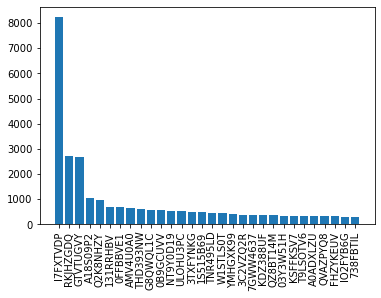

In [50]:
plt.bar(x=topn_abundant_labs.index, height=topn_abundant_labs.values)
plt.xticks(rotation = 90)
plt.show()

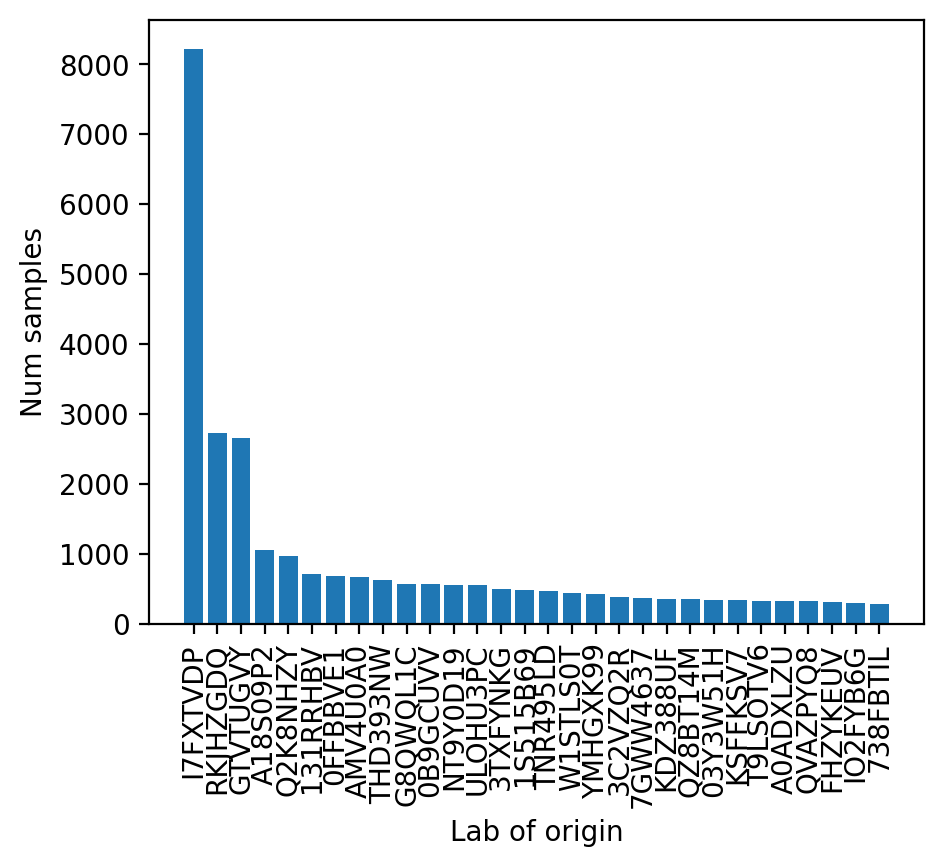

In [52]:
plt.figure(figsize=(5,4), dpi=200)
plt.bar(x=topn_abundant_labs.index, height=topn_abundant_labs.values)
plt.xticks(rotation = 90)
plt.xlabel('Lab of origin')
plt.ylabel('Num samples')
plt.show()

How large is the imbalance?

In [20]:
f'Ratio most abundant : less abundant = {topn_abundant_labs[0]}/{topn_abundant_labs[-1]} = {round(topn_abundant_labs[0]/topn_abundant_labs[-1],3)}'

'Ratio most abundant : less abundant = 8226/284 = 28.965'

In [21]:
f'Ratio second most abundant : less abundant = {topn_abundant_labs[1]}/{topn_abundant_labs[-1]} = {round(topn_abundant_labs[1]/topn_abundant_labs[-1],3)}'

'Ratio second most abundant : less abundant = 2732/284 = 9.62'

It is not terribly imbalanced. However, here I am testing multiclass classification, not the effect of imbalance.

**Strategy:** For this test, I will just UNDERSAMPLE the most abundant classes to the number of samples of the least abundant one. I will not sample multiple times from the same plasmid sequence as I have done before, as it was not really necessary at least for binary classification.

### Reduce data to only selected classes undersampling to have them balanced

In [22]:
obs_per_label = topn_abundant_labs[-1]
print(obs_per_label)

284


In [23]:
sele_labs = topn_abundant_labs.index.to_list()
print(sele_labs)

['I7FXTVDP', 'RKJHZGDQ', 'GTVTUGVY', 'A18S09P2', 'Q2K8NHZY', '131RRHBV', '0FFBBVE1', 'AMV4U0A0', 'THD393NW', 'G8QWQL1C', '0B9GCUVV', 'NT9Y0D19', 'ULOHU3PC', '3TXFYNKG', '1S515B69', 'TNR495LD', 'W1STLS0T', 'YMHGXK99', '3C2VZQ2R', '7GWW4637', 'KDZ388UF', 'QZ8BT14M', '03Y3W51H', 'KSFFKSV7', 'T9LSOTV6', 'A0ADXLZU', 'QVAZPYQ8', 'FHZYKEUV', 'IO2FYB6G', '738FBTIL']


In [24]:
## this is used to select all observations with the selected labels
# sele_index = labels[labels.isin(sele_labs)]
# print(sele_index.value_counts()[:10])
# print(sele_index)

In [25]:
sele_index = pd.Series(dtype=str)
for lab in sele_labs:
    idx = labels[labels == lab]
    sele_index = pd.concat([sele_index, idx.sample(n=obs_per_label, replace=False, random_state=42)])

In [26]:
sele_index.value_counts()

I7FXTVDP    284
RKJHZGDQ    284
IO2FYB6G    284
FHZYKEUV    284
QVAZPYQ8    284
A0ADXLZU    284
T9LSOTV6    284
KSFFKSV7    284
03Y3W51H    284
QZ8BT14M    284
KDZ388UF    284
7GWW4637    284
3C2VZQ2R    284
YMHGXK99    284
W1STLS0T    284
TNR495LD    284
1S515B69    284
3TXFYNKG    284
ULOHU3PC    284
NT9Y0D19    284
0B9GCUVV    284
G8QWQL1C    284
THD393NW    284
AMV4U0A0    284
0FFBBVE1    284
131RRHBV    284
Q2K8NHZY    284
A18S09P2    284
GTVTUGVY    284
738FBTIL    284
dtype: int64

In [27]:
# all indices are unique, so we did not include twice the same sequence
sele_index.index.has_duplicates

False

In [28]:
sele_train = train_vals.loc[sele_index.index].copy()

In [29]:
sele_train = sele_train.join(sele_index.rename('label'))
sele_train = sele_train[['sequence','label']]

In [30]:
sele_train.head()

,sequence,label
6RYTD,CCTGCAGGCAGCTGCGCGCTCGCTCGCTCACTGAGGCCGCCCGGGC...,I7FXTVDP
QAXF7,AAAACGCCAGCAACGCGGCCTTTTTACGGTTCCTGGCCTTTTGCTG...,I7FXTVDP
6R9GK,TCGCCCTTGCTTGTGCCGTGGTGATGGTGGTGATGGTGGTGACCAG...,I7FXTVDP
Z33CT,CTAAATTGTAAGCGTTAATATTTTGTTAAAATTCGCGTTAAATTTT...,I7FXTVDP
7TLWX,GCAGCCGGATCTCAGTGGTGGTGGTGGTGGTGCTCGAGTGCGGCCG...,I7FXTVDP


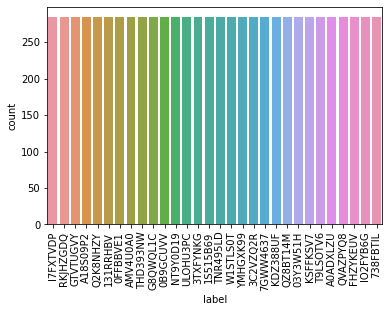

In [31]:
sns.countplot(x=sele_train.label)
plt.xticks(rotation=90)
plt.show()

### Check plasmid length of the subsampled

In [32]:
plasmid_length_sum = []
for lab in sele_labs:
    plasmid_length_sum.append(np.sum([len(seq) for seq in sele_train[sele_train['label'] == lab]['sequence']]))

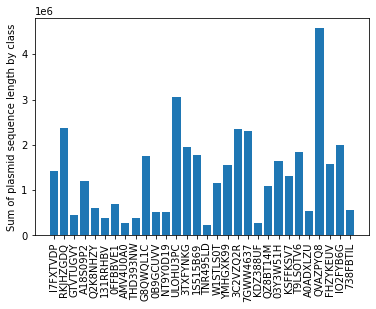

In [33]:
plt.bar(x=sele_labs, height=plasmid_length_sum)
plt.xticks(rotation=90)
plt.ylabel('Sum of plasmid sequence length by class')
plt.show()

The median plasmid length is quite different. Some are quite short

In [34]:
plasmid_length_median = []
for lab in sele_labs:
    plasmid_length_median.append(np.median([len(seq) for seq in sele_train[sele_train['label'] == lab]['sequence']]))

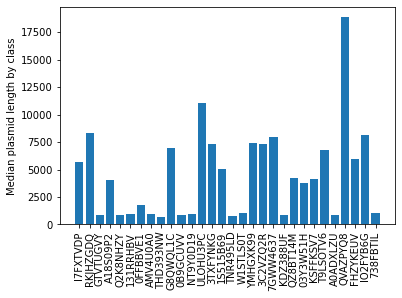

In [35]:
plt.bar(x=sele_labs, height=plasmid_length_median)
plt.xticks(rotation=90)
plt.ylabel('Median plasmid length by class')
plt.show()

The minimum is quite low.

In [36]:
plasmid_length_min = []
for lab in sele_labs:
    plasmid_length_min.append(np.min([len(seq) for seq in sele_train[sele_train['label'] == lab]['sequence']]))

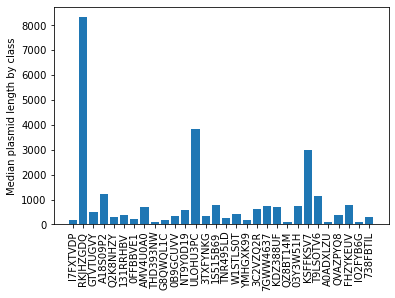

In [37]:
plt.bar(x=sele_labs, height=plasmid_length_min)
plt.xticks(rotation=90)
plt.ylabel('Median plasmid length by class')
plt.show()

There are sequences that are shorter than 100

In [38]:
np.min(plasmid_length_min)

86

### Redo sampling to ensure >100nts length

We can randomly sample from the subset of plasmids above 100nts in length for the classes that are more abundant and see if there are enough.

Alternatives that could also be tried: Concatenating the end of the plasmid with its beggining to get 100nts (since they are circular this can be done) or append the Rev Complement at the end (a winning solution did this)

First, check if all classes have more than `obs_per_label=284` sequences with >100nts and no 'N' (undefined) nucleotides

In [39]:
obs_per_label = topn_abundant_labs[-1]
print(obs_per_label)

284


In [40]:
train_vals['seq_len'] = [len(seq) for seq in train_vals['sequence']]

In [41]:
# get the maximum length of contiguous sequence without any undefined nucleotide
train_vals['min_nonN_seq'] = [min_nonN_seq(seq) for seq in train_vals['sequence']]

In [42]:
train_vals['label'] = labels

In [43]:
min_len = 101 # thld to accept sequences

for lab in sele_labs:
    subset = train_vals[(train_vals['min_nonN_seq'] > min_len) & (train_vals['label'] == lab) ].copy()
    num_above = len(subset)
    if num_above < obs_per_label:
        print(f'WARNING: Label {lab} does only have {num_above} sequences above {min_len}bp, insufficient to get {obs_per_label}')
    else:
        print(f'Label {lab} is fine, it has {num_above} sequences above {min_len}bp and no N')

Label I7FXTVDP is fine, it has 8163 sequences above 101bp and no N
Label RKJHZGDQ is fine, it has 2732 sequences above 101bp and no N
Label GTVTUGVY is fine, it has 2657 sequences above 101bp and no N
Label A18S09P2 is fine, it has 1054 sequences above 101bp and no N
Label Q2K8NHZY is fine, it has 969 sequences above 101bp and no N
Label 131RRHBV is fine, it has 698 sequences above 101bp and no N
Label 0FFBBVE1 is fine, it has 679 sequences above 101bp and no N
Label AMV4U0A0 is fine, it has 659 sequences above 101bp and no N
Label THD393NW is fine, it has 619 sequences above 101bp and no N
Label G8QWQL1C is fine, it has 572 sequences above 101bp and no N
Label 0B9GCUVV is fine, it has 554 sequences above 101bp and no N
Label NT9Y0D19 is fine, it has 552 sequences above 101bp and no N
Label ULOHU3PC is fine, it has 548 sequences above 101bp and no N
Label 3TXFYNKG is fine, it has 497 sequences above 101bp and no N
Label 1S515B69 is fine, it has 486 sequences above 101bp and no N
Label 

All of them are okay except the lass class, so will decrease `obs_per_label` to 283

In [44]:
obs_per_label = 283

Since all classes have this number of sequences, I will randomly sample from the subset that satisfy this condition

In [45]:
min_len = 101 # thld to accept sequences

sele_train = []
for lab in sele_labs:
    subset = train_vals[(train_vals['min_nonN_seq'] > min_len) & (train_vals['label'] == lab) ].copy()
    sele_train.append(subset.sample(n=obs_per_label, replace=False, random_state=42))

In [46]:
sele_train = pd.concat(sele_train)

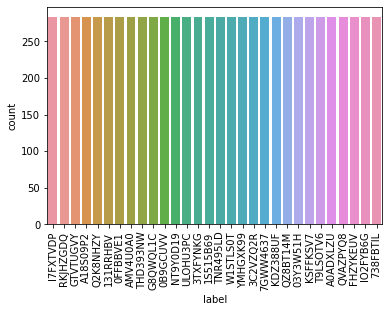

In [47]:
sns.countplot(x='label', data=sele_train)
plt.xticks(rotation=90)
plt.show()

### Get subsequences

For each sequence, take 1 subsequence randomly with random Reverse Translatation

In [48]:
num_subseq_per_seq = 1
seq_len = 101


random_seq_sele = []

np.random.seed(42)

for seq in sele_train['sequence']:
    sub_list = []
    for _ in range(num_subseq_per_seq):
        # if sequence is shorter, take entire sequence and it will be padded
        # if it has a N on it, this is a problem and would be better to manually analyze and discard this observation before running cell
        if len(seq) <= seq_len:
            if 'N' in seq.upper(): 
                raise ValueError("Can't process sequences, found a sequence shorter than seq_len and with a N character...discard this sequence")
            # with probability 0.5 make the Reverse Complement of that sequence
            if np.random.rand() > .5:
                sub_list.append(seq)
            else:
                sub_list.append(rev_comp(seq))
        else:
            # if sequence is longer, need to randomly select a subsequence
            subseq ='' # initialize to enter while
            # keep looking for subsequences until they do not have any N (this might bias a bit the initial positions)
            while ('N' in subseq.upper()) or (len(subseq) != seq_len):
                start_pos = np.random.randint(len(seq) - seq_len + 1)
                subseq = seq[start_pos:start_pos+seq_len]
            # with probability 0.5 make the Reverse Complement of that sequence
            if np.random.rand() > .5:
                sub_list.append(subseq)
            else:
                sub_list.append(rev_comp(subseq))
    random_seq_sele.append(sub_list)

In [49]:
# 1 subsequences per each sequence
print(f'Expected {len(sele_labs) * obs_per_label * num_subseq_per_seq} sequences')
print('Got:', np.array(random_seq_sele).shape)

Expected 8490 sequences
Got: (8490, 1)


In [50]:
sele_train['random_seq_sele'] = random_seq_sele

I don't look at repeats here bc there are probably some as I take randomly

In [51]:
# there are 241 repeats in this subset, not a problem, it can just happen by random selection and it is not much compared to 5000 total examples
print(sele_train['random_seq_sele'].shape)
print(np.sum(sele_train['random_seq_sele'].value_counts() > 1))

(8490,)
241


Number of repeated sequences divided by class. Not many compared to 283 seqs we have per class

In [52]:
rep_seqs = []
for lab in sele_labs:
    rep_seqs.append(np.sum(sele_train[sele_train['label'] == lab]['random_seq_sele'].value_counts() > 1))

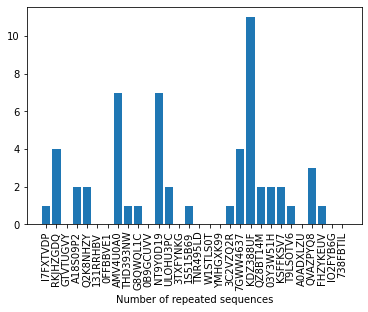

In [53]:
plt.bar(x=sele_labs, height=rep_seqs)
plt.xticks(rotation=90)
plt.xlabel('Number of repeated sequences')
plt.show()

### Convert labels to integer values

In [54]:
label_key = {}
for i, lab in enumerate(sele_labs):
    label_key[lab] = str(i)

In [55]:
label_key

{'I7FXTVDP': '0',
 'RKJHZGDQ': '1',
 'GTVTUGVY': '2',
 'A18S09P2': '3',
 'Q2K8NHZY': '4',
 '131RRHBV': '5',
 '0FFBBVE1': '6',
 'AMV4U0A0': '7',
 'THD393NW': '8',
 'G8QWQL1C': '9',
 '0B9GCUVV': '10',
 'NT9Y0D19': '11',
 'ULOHU3PC': '12',
 '3TXFYNKG': '13',
 '1S515B69': '14',
 'TNR495LD': '15',
 'W1STLS0T': '16',
 'YMHGXK99': '17',
 '3C2VZQ2R': '18',
 '7GWW4637': '19',
 'KDZ388UF': '20',
 'QZ8BT14M': '21',
 '03Y3W51H': '22',
 'KSFFKSV7': '23',
 'T9LSOTV6': '24',
 'A0ADXLZU': '25',
 'QVAZPYQ8': '26',
 'FHZYKEUV': '27',
 'IO2FYB6G': '28',
 '738FBTIL': '29'}

In [56]:
sele_train['bin_label'] = [label_key[lab] for lab in sele_train['label']]

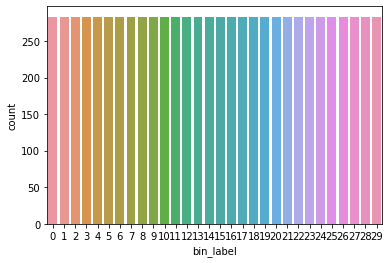

In [57]:
sns.countplot(x='bin_label', data=sele_train)
plt.show()

## Conver to kmers

In [58]:
kmer_size = 6

Use their function seq2kmer from `motif/motif_utils.py`

In [59]:
def seq2kmer(seq, k):
    """
    Convert original sequence to kmers
    
    Arguments:
    seq -- str, original sequence.
    k -- int, kmer of length k specified.
    
    Returns:
    kmers -- str, kmers separated by space

    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    kmers = " ".join(kmer)
    return kmers

Example

In [60]:
sele_train['kmer_rand'] = [[seq2kmer(seq, kmer_size) for seq in subseq] for subseq in sele_train['random_seq_sele']]

In [61]:
sele_train['kmer_rand']

sequence_id
VIS02    [CCCTGC CCTGCC CTGCCA TGCCAC GCCACT CCACTC CAC...
3WSN2    [GACCGA ACCGAC CCGACT CGACTT GACTTC ACTTCA CTT...
IMFLG    [TAACCA AACCAT ACCATG CCATGA CATGAG ATGAGT TGA...
L123V    [CCCAGG CCAGGC CAGGCT AGGCTA GGCTAG GCTAGC CTA...
YSZF0    [TTATTT TATTTT ATTTTT TTTTTC TTTTCT TTTCTA TTC...
                               ...                        
J7YSD    [GGGACT GGACTT GACTTC ACTTCA CTTCAT TTCATG TCA...
4WRQP    [GCCGCC CCGCCG CGCCGC GCCGCA CCGCAT CGCATT GCA...
ZHZRA    [GCATTT CATTTT ATTTTT TTTTTT TTTTTT TTTTTC TTT...
AIAH0    [TCCTGA CCTGAC CTGACG TGACGT GACGTT ACGTTG CGT...
8ION0    [CCACGG CACGGG ACGGGG CGGGGC GGGGCC GGGCCC GGC...
Name: kmer_rand, Length: 8490, dtype: object

Now, I need to get individual subsequence kmer represnetations as each row, so numbers of rows will grow 8 times more...

In [62]:
final_data = []

for seq_idx, row in sele_train.iterrows():
    bin_label = row['bin_label']
    for seq in row['kmer_rand']:
        final_data.append({
            'sequence_id': seq_idx,
            'sequence': seq,
            'label': bin_label
        })

final_data = pd.DataFrame.from_records(final_data)

In [63]:
final_data.shape

(8490, 3)

In [64]:
final_data.set_index('sequence_id', inplace=True)

In [65]:
final_data

,sequence,label
sequence_id,,
VIS02,CCCTGC CCTGCC CTGCCA TGCCAC GCCACT CCACTC CACT...,0
3WSN2,GACCGA ACCGAC CCGACT CGACTT GACTTC ACTTCA CTTC...,0
IMFLG,TAACCA AACCAT ACCATG CCATGA CATGAG ATGAGT TGAG...,0
L123V,CCCAGG CCAGGC CAGGCT AGGCTA GGCTAG GCTAGC CTAG...,0
YSZF0,TTATTT TATTTT ATTTTT TTTTTC TTTTCT TTTCTA TTCT...,0
...,...,...
J7YSD,GGGACT GGACTT GACTTC ACTTCA CTTCAT TTCATG TCAT...,29
4WRQP,GCCGCC CCGCCG CGCCGC GCCGCA CCGCAT CGCATT GCAT...,29
ZHZRA,GCATTT CATTTT ATTTTT TTTTTT TTTTTT TTTTTC TTTT...,29


## Split data

Original finetuning data is split between a dev.tsv file with 1000 observations and a train.tsv file with 32367 observations. I think the dev set is used during training to evaluate the accuracy on a held-out dataset (test accuracy). 

**SINCE I AM NOT COMPARING MODELS BETWEEN THEM, BECAUSE THE DATA I USE IN EVERYONE IS DIFFEERENT, THERE IS NO USE FOR A TRAIN DATASET THAT IS NOT USED TO EVALUATE OR CHOOSE HYPERPARAMETERS OF THE MODEL AND IS ONLY USED TO COMPARE ACROSS MODELS, HENCE IT IS FINE TO JUST USE THE DEV SET, WHICH IS NOT USED DURING FINETUNING TO SET ANY KIND OF PARAMETER**

I want a perfectly balanced test set. So I manually subsample each class to about 1000 total sequences (closest multiple to number of classes)

In [66]:
num_dev_class = math.floor(1000/len(sele_labs))

In [67]:
num_dev_class

33

In [68]:
dev_data = final_data.groupby('label').sample(num_dev_class, replace=False, random_state=42).copy()

to get the train_data I need to make a list from 0 to len(train_data) excluding those indices in dev_data

In [69]:
train_data = final_data[~(final_data.index.isin(dev_data.index))].copy()

They are balanced

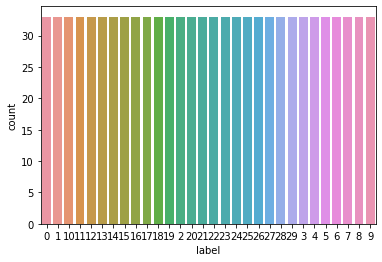

In [71]:
sns.countplot(x='label', data=dev_data)
plt.show()

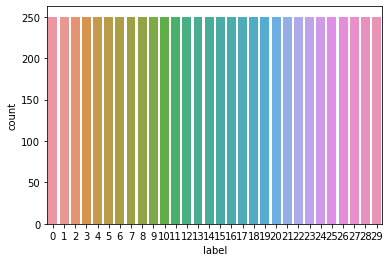

In [72]:
sns.countplot(x='label', data=train_data)
plt.show()

In [73]:
dev_data

,sequence,label
sequence_id,,
9TBQW,TCTTGT CTTGTA TTGTAC TGTACA GTACAA TACAAA ACAA...,0
TIL8T,TGCAGT GCAGTG CAGTGC AGTGCT GTGCTT TGCTTC GCTT...,0
W0G1B,CGTCGA GTCGAC TCGACT CGACTG GACTGC ACTGCA CTGC...,0
UDFC0,ATCTCA TCTCAA CTCAAT TCAATT CAATTA AATTAG ATTA...,0
AEVPG,GCCTAA CCTAAT CTAATG TAATGA AATGAG ATGAGT TGAG...,0
...,...,...
OBHO6,CATAAT ATAATG TAATGG AATGGT ATGGTG TGGTGC GGTG...,9
VLUUC,CAAACG AAACGC AACGCT ACGCTA CGCTAA GCTAAT CTAA...,9
RKL6M,GCTCTA CTCTAA TCTAAA CTAAAT TAAATC AAATCG AATC...,9


In [74]:
train_data

,sequence,label
sequence_id,,
VIS02,CCCTGC CCTGCC CTGCCA TGCCAC GCCACT CCACTC CACT...,0
3WSN2,GACCGA ACCGAC CCGACT CGACTT GACTTC ACTTCA CTTC...,0
IMFLG,TAACCA AACCAT ACCATG CCATGA CATGAG ATGAGT TGAG...,0
L123V,CCCAGG CCAGGC CAGGCT AGGCTA GGCTAG GCTAGC CTAG...,0
YSZF0,TTATTT TATTTT ATTTTT TTTTTC TTTTCT TTTCTA TTCT...,0
...,...,...
85RGS,GTTCAT TTCATC TCATCC CATCCA ATCCAT TCCATA CCAT...,29
J7YSD,GGGACT GGACTT GACTTC ACTTCA CTTCAT TTCATG TCAT...,29
4WRQP,GCCGCC CCGCCG CGCCGC GCCGCA CCGCAT CGCATT GCAT...,29


### Shuffle

As it is now, observations are ordered by label. Will shuffle it just in case the model does not shuffle input data to take the 32 batch sizes (I bet it does)

In [75]:
train_data = train_data.sample(frac=1, random_state=42)

In [76]:
dev_data

,sequence,label
sequence_id,,
9TBQW,TCTTGT CTTGTA TTGTAC TGTACA GTACAA TACAAA ACAA...,0
TIL8T,TGCAGT GCAGTG CAGTGC AGTGCT GTGCTT TGCTTC GCTT...,0
W0G1B,CGTCGA GTCGAC TCGACT CGACTG GACTGC ACTGCA CTGC...,0
UDFC0,ATCTCA TCTCAA CTCAAT TCAATT CAATTA AATTAG ATTA...,0
AEVPG,GCCTAA CCTAAT CTAATG TAATGA AATGAG ATGAGT TGAG...,0
...,...,...
OBHO6,CATAAT ATAATG TAATGG AATGGT ATGGTG TGGTGC GGTG...,9
VLUUC,CAAACG AAACGC AACGCT ACGCTA CGCTAA GCTAAT CTAA...,9
RKL6M,GCTCTA CTCTAA TCTAAA CTAAAT TAAATC AAATCG AATC...,9


In [77]:
dev_data = dev_data.sample(frac=1, random_state=42)

In [78]:
dev_data

,sequence,label
sequence_id,,
5EPXG,GAGTTA AGTTAC GTTACA TTACAT TACATG ACATGA CATG...,14
NS84K,GTACCC TACCCA ACCCAA CCCAAA CCAAAG CAAAGC AAAG...,18
WRD08,ACACAA CACAAC ACAACA CAACAT AACATA ACATAT CATA...,22
Y3FWP,ATATCT TATCTA ATCTAA TCTAAT CTAATC TAATCT AATC...,17
C0G1M,TGAATA GAATAT AATATT ATATTT TATTTT ATTTTG TTTT...,10
...,...,...
7U5ME,GGCAAG GCAAGC CAAGCA AAGCAA AGCAAG GCAAGC CAAG...,11
OKUGU,CTCCTC TCCTCC CCTCCC CTCCCT TCCCTG CCCTGA CCTG...,16
BEISD,CTCCTG TCCTGT CCTGTG CTGTGG TGTGGG GTGGGC TGGG...,6


### Export

Finally, export this dataframes in the appropriate format and in a .csv file that could be read back to pandas (which contains information about the indices!)

In [79]:
train_data.to_csv(f'{path_prefix}/transformers/4_geathirty/in_data/train_data.csv')
dev_data.to_csv(f'{path_prefix}/transformers/4_geathirty/in_data/dev_data.csv')

Model will use these tsv files.

In [80]:
train_data.to_csv(f'{path_prefix}/transformers/4_geathirty/in_data/train.tsv', sep='\t', index=False)
dev_data.to_csv(f'{path_prefix}/transformers/4_geathirty/in_data/dev.tsv', sep='\t', index=False)